# Performance evaluation and benchmarking

In this notebook we will go step-by-step through the model evaluation part of our paper, as well as through the benchmarking part, where we compare our simulation results with a good hand-full of different (well-established) hydrological models.

For more information read the experiment description in our paper:

**TODO**: Include Ref

Note:
If you want to run this notebook locally and reproduce the figures of our paper
- make sure you have our pre-trained models. See the [README.md](link) in the repository for further instructions.

- make sure to have the CAMELS benchmark data set. See the [README.md](link) in the repository for further instructions.

#### Adapt the lines below according to your local system

In [1]:
# Needed if no precomputed results are used. Main directory containing all runs
BASE_RUN_DIR = "/home/mgauch/ealstm_regional_modeling/runs/evaluate/"

# Path to the benchmark model folders containing the basin netCDF files
BENCHMARK_DIR = "/home/mgauch/ealstm_regional_modeling/data/netcdf/"

# Path to the main directory of this repository
BASE_CODE_DIR = "/home/mgauch/ealstm_regional_modeling"

In [2]:
# Imports
import pickle
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from scipy.stats import wilcoxon

# Add repository to Python path
sys.path.append(BASE_CODE_DIR)
from papercode.plotutils import model_draw_style, model_specs, ecdf
from papercode.evalutils import (get_run_dirs, eval_datadriven_models, 
                                 eval_benchmark_models, get_pvals, 
                                 get_mean_basin_performance, get_cohens_d)
from papercode.metrics import *

Definition of global variables. 

**Note**: If you want to recompute all model metrics, change the `PRECOMPUTED_DATA` flag to `False`. No GPU is required. If you want to use the pre-calculated metrics, make sure the flag is set to `True`

In [3]:
# If True load pre-computed metrics from pickle file, else re-calculate everything
PRECOMPUTED_DATA = False

# Convert to PosixPaths
BASE_RUN_DIR = Path(BASE_RUN_DIR)
BENCHMARK_DIR = Path(BENCHMARK_DIR)

# Set of evaluation functions
EVAL_FUNCS = {'NSE': calc_nse, 
              'alpha_nse': calc_alpha_nse, 
              'beta_nse': calc_beta_nse,
              'FHV': calc_fdc_fhv, 
              'FLV': calc_fdc_flv, 
              'FMS': calc_fdc_fms}

# Evaluate data-driven models

First, we compare the XGBoost model with the 6 different settings of LSTM-based models, that we trained for this paper. These are three different model settings:

1. EA-LSTM: Our proposed adaption of the LSTM recurrent neural network, where the static catchment characteristics are used to modulate the input gate.
2. LSTM: The standard LSTM architecture, where the static catchment characteristics are concatenated to the meterological inputs at each time step.
3. LSTM (no static inputs): A standard LSTM that is only trained using the meteorological forcing data.

All three model configurations were trained using two different loss functions:

1. MSELoss: The standard mean squared error loss.
2. NSELoss: Our proposed loss function, which approximates the basin averaged NSE. For more details see the Method section of our manuscript.

For each of the 6 settings, we trained 8 models (using different random initializations) and furthermore combined these 8 models to an ensemble (by averaging the k=8 model simulations)

In [4]:
if PRECOMPUTED_DATA:
    print("Loaded data from pre-computed pickle file")
    with open("all_metrics.p", "rb") as fp:
        all_metrics = pickle.load(fp)
else:
    all_metrics = {}
    for func_name, func in EVAL_FUNCS.items():
        tqdm.tqdm.write(f"Calculating metric: {func_name}")
        model_metrics = {}
        for model, specs in model_specs.items():
            run_dirs = get_run_dirs(root_dir=BASE_RUN_DIR, model=specs["model"], loss=specs["loss"])
            model_metrics[model] = eval_datadriven_models(run_dirs=run_dirs, func=func)

        all_metrics[func_name] = model_metrics

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating metric: NSE


  0%|          | 0/3 [00:00<?, ?it/s]

Calculating metric: alpha_nse


  0%|          | 0/3 [00:00<?, ?it/s]

Calculating metric: beta_nse


  0%|          | 0/3 [00:00<?, ?it/s]

Calculating metric: FHV


  0%|          | 0/3 [00:00<?, ?it/s]

Calculating metric: FLV


  0%|          | 0/3 [00:00<?, ?it/s]

Calculating metric: FMS


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


## Tabular comparison

In a first step, we look at the mean, median NSE as well as the number of catastrophic failures. Catastrophic failures are defined as the number of basins, where the model has a NSE <= 0.
We calculate the mean of each of this three statistics over the model (n=8) model repetitions and report the standard deviation here as well. The repetitions are denoted as `ensemble=False` in the table below.

In [5]:
data = []
for model_type, models in all_metrics["NSE"].items():
    if model_type == "benchmarks":
        continue
    seeds = [k for k in models.keys() if "seed" in k]
    means, medians, failures = [], [], []
    for seed in seeds:
        nses = list(models[seed].values())
        means.append(np.mean(nses))
        medians.append(np.median(nses))
        failures.append(len([v for v in nses if v <= 0]))
    data_sing = {'model_type': model_draw_style[model_type]["label"], 
                 'ensemble': False, 
                 'mean': np.mean(means), 
                 'std_mean': np.std(means),
                 'median': np.mean(medians),
                 'std_median': np.std(medians),
                 'failures': np.mean(failures),
                 'std_failures': np.std(failures)}
    data.append(data_sing)
    values = list(models["ensemble"].values())
    data_ensemble = {'model_type': model_draw_style[model_type]["label"],
                   'ensemble': True,
                   'mean': np.mean(values),
                   'median': np.median(values),
                   'failures': len([v for v in values if v < 0]) }
    data.append(data_ensemble)

df = pd.DataFrame(data)
df = df.set_index(keys=["model_type", "ensemble"])
df

failures      mean    median  \
model_type                  ensemble                                 
XGBoost MSE                 False       37.000  0.365035  0.598360   
                            True        27.000  0.469262  0.630555   
XGBoost NSE                 False        9.500  0.529034  0.568021   
                            True         6.000  0.547320  0.578084   
EA-LSTM MSE                 False        9.125  0.631087  0.709609   
                            True         6.000  0.679790  0.739772   
EA-LSTM NSE                 False        3.375  0.659997  0.699602   
                            True         3.000  0.703461  0.743842   
LSTM MSE                    False        5.625  0.664064  0.726058   
                            True         3.000  0.707204  0.757268   
LSTM NSE                    False        1.750  0.686619  0.731623   
                            True         2.000  0.719063  0.759361   
LSTM (no static inputs) MSE False       44.250  0.235767  0.599360   
                            True        31.000  0.357971  0.646646   
LSTM (no static inputs) NSE False       28.000  0.393980  0.593262   
                            True        20.000  0.492559  0.642070   

                                      std_failures  std_mean  std_median  
model_type                  ensemble                                      
XGBoost MSE                 False         0.816497  0.015698    0.002320  
                            True               NaN       NaN         NaN  
XGBoost NSE                 False         0.500000  0.005034    0.003211  
                            True               NaN       NaN         NaN  
EA-LSTM MSE                 False         0.927025  0.017903    0.005168  
                            True               NaN       NaN         NaN  
EA-LSTM NSE                 False         1.653595  0.036099    0.033411  
                            True               NaN       NaN         NaN  
LSTM MSE                    False         1.932453  0.012097    0.003281  
                            True               NaN       NaN         NaN  
LSTM NSE                    False         0.661438  0.012865    0.002156  
                            True               NaN       NaN         NaN  
LSTM (no static inputs) MSE False         3.960745  0.048782    0.004920  
                            True               NaN       NaN         NaN  
LSTM (no static inputs) NSE False         3.427827  0.058873    0.008412  
                            True               NaN       NaN         NaN

## Cumulative density function plot

Here we look at the CDF of the NSEs for each of our 6 configurations. 

- `solid` lines mark models trained with `NSELoss`, `dashed` lines mark models trained with `MSELoss`
- `saturated colors` are ensemble (n=8) means, `non-saturated colors` is a single model. Here we took seed 111 of each model, which is rather arbitrary but from the table above we seed that the mean/median NSE are robust between different random initializations.
- `square` marker denote models trained with static features, while `triangle` markers denote models trained without static features
- `green` is our proposed `EA-LSTM`, `orange` the standard LSTM with static features and `purple` the standard LSTM trained only on meteorological forcing data.

Text(0.5, 1.0, 'Effect of (not) using static catchment attributes')

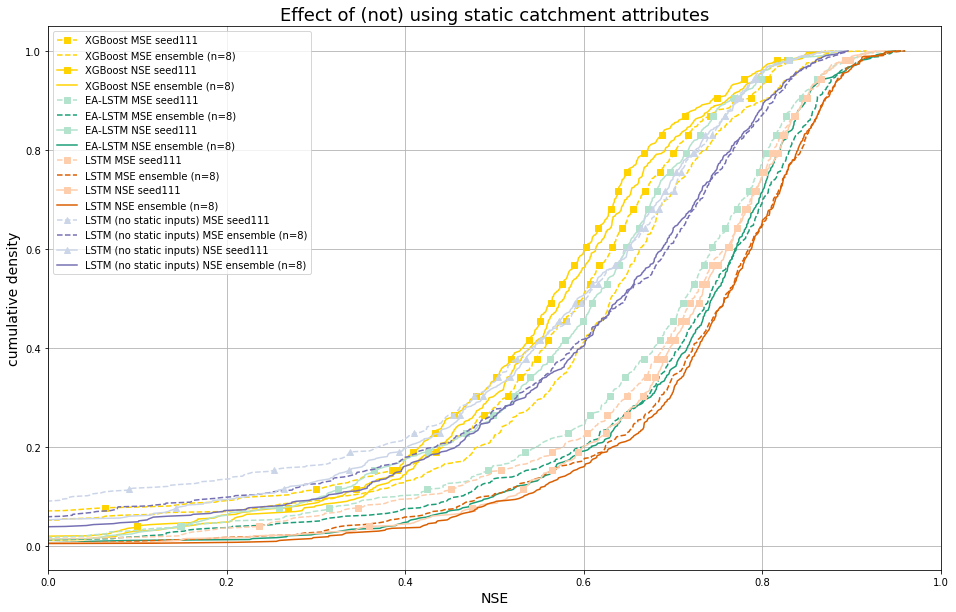

In [6]:
fig, ax = plt.subplots(figsize=(16,10))

for model_type, models in all_metrics["NSE"].items():
    if 'lstm' in model_type or 'xgboost' in model_type:
        # single seed
        if len(models.keys()) == 1:
            continue
        values = list(models['seed111'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=f"{model_draw_style[model_type]['label']} seed111",
                color=model_draw_style[model_type]["single_color"], 
                marker=model_draw_style[model_type]['marker'], 
                markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
        # ensemble seed
        values = list(models['ensemble'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_, 
                label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
                color=model_draw_style[model_type]['ensemble_color'], 
                linestyle=model_draw_style[model_type]['linestyle'])
    
ax.set_xlim(0, 1)
ax.grid(True)
ax.legend(loc='upper left')
ax.set_xlabel('NSE', fontsize=14)
ax.set_ylabel('cumulative density', fontsize=14)
ax.set_title("Effect of (not) using static catchment attributes", fontsize=18)

## Calculate statistical significance.

1. Calculate statistical significance between LSTM trained with and without static features using either MSE or NSE as loss function.

2. Calculate statistical significance between EA-LSTM and standard LSTM (with static features)

We always report the max, mean p-value between all possible seed combinations (n=8^2=64) as well as the p-value between the ensemble means

In [7]:
print("### NSE:")
print("XGBoost with statics, optimized with MSE or LSTM with statics, optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='xgboost_MSE', 
                                         model2='lstm_MSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nWith or without statics, optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_no_static_MSE', 
                                         model2='lstm_MSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nWith or without statics, optimized with NSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_no_static_NSE', 
                                         model2='lstm_NSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nEA-LSTM vs LSTM (with statics), optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_MSE', 
                                         model2='ealstm_MSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nEA-LSTM vs LSTM (with statics), optimized with NSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_NSE', 
                                         model2='ealstm_NSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

values1 = get_mean_basin_performance(all_metrics["NSE"], model="ealstm_NSE")
values1 = list(values1.values())
values2 = get_mean_basin_performance(all_metrics["NSE"], model="lstm_NSE")
values2 = list(values2.values())
d = get_cohens_d(values1, values2)
print(f"Effect size using Cohen's d is: d={d:.3f}")


print("\nEA-LSTM optimized with NSE vs. EA-LSTM optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='ealstm_NSE', 
                                         model2='ealstm_MSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

print("\nLSTM  without static features optimized with NSE vs. optimized with MSE")
p_val_single, p_val_ensemble = get_pvals(all_metrics["NSE"], 
                                         model1='lstm_no_static_MSE', 
                                         model2='lstm_no_static_NSE')
print(f"Single models: p-value={p_val_single:.2e}")
print(f"Ensemble mean: {p_val_ensemble:.2e}")

### NSE:
XGBoost with statics, optimized with MSE or LSTM with statics, optimized with MSE
Single models: p-value=6.63e-77
Ensemble mean: 1.26e-74

With or without statics, optimized with MSE
Single models: p-value=1.15e-75
Ensemble mean: 3.99e-68

With or without statics, optimized with NSE
Single models: p-value=8.76e-81
Ensemble mean: 3.32e-75

EA-LSTM vs LSTM (with statics), optimized with MSE
Single models: p-value=6.07e-20
Ensemble mean: 2.90e-20

EA-LSTM vs LSTM (with statics), optimized with NSE
Single models: p-value=5.75e-51
Ensemble mean: 2.46e-18
Effect size using Cohen's d is: d=0.110

EA-LSTM optimized with NSE vs. EA-LSTM optimized with MSE
Single models: p-value=8.92e-08
Ensemble mean: 9.88e-01

LSTM  without static features optimized with NSE vs. optimized with MSE
Single models: p-value=4.34e-02
Ensemble mean: 8.09e-01


# Compare against benchmark models

Now we compare our model, the `EA-LSTM` optimized with `NSELoss`, and `XGBoost`, against the set of benchmark models. Here, we only use the model results from the set of basins that were modeled by all models (the benchmark models and our models).

First, we have to calculate the metrics for all basins and benchmark models (or load the data from the precomputed file)

In [8]:
if not PRECOMPUTED_DATA:
    for metric in all_metrics.keys():
        tqdm.tqdm.write(f"Calculating metric: {metric}")
        all_metrics[metric]["benchmarks"] = eval_benchmark_models(netcdf_folder=BENCHMARK_DIR, 
                                                                  func=EVAL_FUNCS[metric])
else:
    print("Evaluation data of benchmark models already exist in pre-computed data")

  0%|          | 0/671 [00:00<?, ?it/s]

Calculating metric: NSE


  1%|          | 8/671 [00:00<00:09, 73.42it/s]

Calculating metric: alpha_nse


  1%|          | 8/671 [00:00<00:08, 75.49it/s]

Calculating metric: beta_nse


  1%|          | 7/671 [00:00<00:11, 60.25it/s]

Calculating metric: FHV


  1%|          | 6/671 [00:00<00:12, 52.47it/s]

Calculating metric: FLV


  1%|          | 7/671 [00:00<00:11, 58.35it/s]

Calculating metric: FMS


100%|██████████| 671/671 [00:12<00:00, 55.01it/s]


In [ ]:
if not PRECOMPUTED_DATA:
    with open("all_metrics.p", "wb") as fp:
        pickle.dump(all_metrics, fp)
    print("Stored precomputed data in 'all_metrics.p'")

In [9]:
# find all basins modeled by all benchmarks
basins = frozenset(list(all_metrics["NSE"]["ealstm_NSE"]["ensemble"].keys()))
basins = basins.intersection(all_metrics["NSE"]["xgboost_MSE"]["ensemble"].keys())
basins = basins.intersection(all_metrics["NSE"]["xgboost_NSE"]["ensemble"].keys())
for model, results in all_metrics["NSE"]["benchmarks"].items():
    basins = basins.intersection(list(results.keys()))
len(basins)

448

In [10]:
# get subset of all metrics for these share basins
sub_metrics = {metric: defaultdict(dict) for metric in all_metrics.keys()}
for metric, model_metric in all_metrics.items():
    for model_type, models in model_metric.items():
        for model, results in models.items():
            sub_metrics[metric][model_type][model] = {}
            for basin, nse in results.items():
                if basin in basins:
                    sub_metrics[metric][model_type][model][basin] = nse

Text(0.5, 1.0, 'Benchmarking against CONUS-wide calibrated hydrological models')

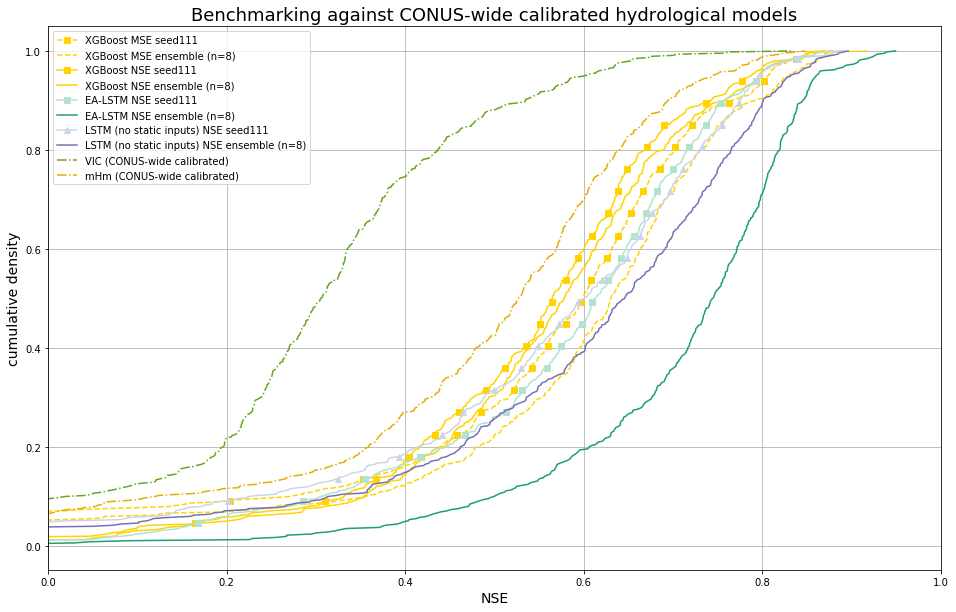

In [11]:
fig, ax = plt.subplots(figsize=(16,10))

for model_type, models in sub_metrics["NSE"].items():
    if (model_type == "ealstm_NSE") or (model_type == "lstm_no_static_NSE") or (model_type == "xgboost_MSE") or (model_type == "xgboost_NSE"):
        # single seed
        values = list(models['seed111'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=f"{model_draw_style[model_type]['label']} seed111",
                color=model_draw_style[model_type]["single_color"], 
                marker=model_draw_style[model_type]['marker'], 
                markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
        # ensemble seed
        values = list(models['ensemble'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_, 
                label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
                color=model_draw_style[model_type]['ensemble_color'], 
                linestyle=model_draw_style[model_type]['linestyle'])
    elif model_type == "benchmarks":
        for benchmark_model, benchmark_result in models.items():
            if "conus" in benchmark_model:
                values = list(benchmark_result.values())
                bin_, cdf_ = ecdf(values)
                ax.plot(bin_,
                        cdf_, 
                        label=model_draw_style[benchmark_model]['label'], 
                        color=model_draw_style[benchmark_model]['color'], 
                        linestyle=model_draw_style[benchmark_model]['linestyle'])
    
ax.set_xlim(0, 1)
ax.grid(True)
ax.legend(loc='upper left')
ax.set_xlabel('NSE', fontsize=14)
ax.set_ylabel('cumulative density', fontsize=14)
ax.set_title("Benchmarking against CONUS-wide calibrated hydrological models", fontsize=18)

In [12]:
vic_count = 0
mhm_count = 0
xgb_count = 0
xgb_vic_count = 0
for basin in basins:
    lstm_nse = sub_metrics["NSE"]["ealstm_NSE"]["ensemble"][basin]
    if sub_metrics["NSE"]["benchmarks"]["VIC_conus"][basin] >= lstm_nse:
        vic_count += 1
    if sub_metrics["NSE"]["benchmarks"]["mHm_conus"][basin] >= lstm_nse:
        mhm_count += 1
    if sub_metrics["NSE"]["xgboost_MSE"]["ensemble"][basin] >= lstm_nse:
        xgb_count += 1
    if sub_metrics["NSE"]["xgboost_MSE"]["ensemble"][basin] >= sub_metrics["NSE"]["benchmarks"]["VIC_conus"][basin]:
        xgb_vic_count += 1
        
print(f"VIC is better (or equal) than EA-LSTM ensemble mean in {vic_count}/{len(basins)} basins")
print(f"mHm is better (or equal) than EA-LSTM ensemble mean in {mhm_count}/{len(basins)} basins")
print(f"XGBoost is better (or equal) than EA-LSTM ensemble mean in {xgb_count}/{len(basins)} basins")
print(f"XGBoost is better (or equal) than VIC_CONUS mean in {xgb_vic_count}/{len(basins)} basins")

VIC is better (or equal) than EA-LSTM ensemble mean in 2/448 basins
mHm is better (or equal) than EA-LSTM ensemble mean in 18/448 basins
XGBoost is better (or equal) than EA-LSTM ensemble mean in 44/448 basins
XGBoost is better (or equal) than VIC_CONUS mean in 424/448 basins


Text(0.5, 1.0, 'Benchmarking against basin-wise calibrated hydrological models')

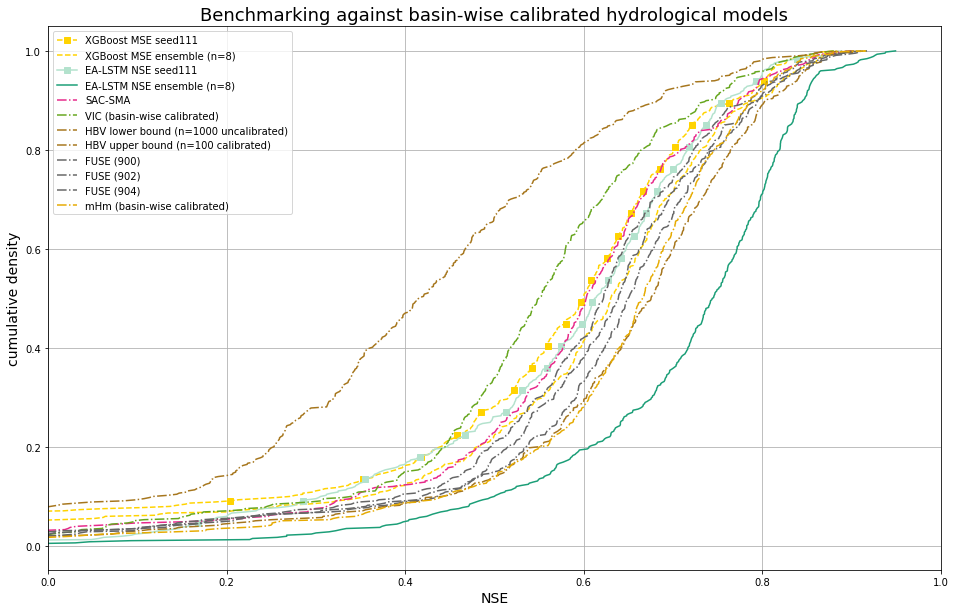

In [13]:
fig, ax = plt.subplots(figsize=(16,10))

for model_type, models in sub_metrics["NSE"].items():
    if model_type == "ealstm_NSE" or model_type == "xgboost_MSE":
        # single seed
        values = list(models['seed111'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_,
                label=f"{model_draw_style[model_type]['label']} seed111",
                color=model_draw_style[model_type]["single_color"], 
                marker=model_draw_style[model_type]['marker'], 
                markevery=20, 
                linestyle=model_draw_style[model_type]['linestyle'])
        
        # ensemble seed
        values = list(models['ensemble'].values())
        bin_, cdf_ = ecdf(values)
        ax.plot(bin_,
                cdf_, 
                label=f"{model_draw_style[model_type]['label']} ensemble (n=8)", 
                color=model_draw_style[model_type]['ensemble_color'], 
                linestyle=model_draw_style[model_type]['linestyle'])
    elif model_type == "benchmarks":
        for benchmark_model, benchmark_result in models.items():
            if not "conus" in benchmark_model:
                values = list(benchmark_result.values())
                bin_, cdf_ = ecdf(values)
                ax.plot(bin_,
                        cdf_, 
                        label=model_draw_style[benchmark_model]['label'], 
                        color=model_draw_style[benchmark_model]['color'], 
                        linestyle=model_draw_style[benchmark_model]['linestyle'])
    
ax.set_xlim(0, 1)
ax.grid(True)
ax.legend(loc='upper left')
ax.set_xlabel('NSE', fontsize=14)
ax.set_ylabel('cumulative density', fontsize=14)
ax.set_title("Benchmarking against basin-wise calibrated hydrological models", fontsize=18)

In [14]:
data = []
for model, desc in [("ealstm_NSE", "EA-LSTM with NSE"), ("xgboost_MSE", "XGBoost with MSE"), ("xgboost_NSE", "XGBoost with NSE")]:
    single_model = {'model': desc, 'ensemble': False}
    ensemble_mean = {'model': desc, 'ensemble': True}
    # get EA-LSTM stats for all metrics
    for metric, metric_data in sub_metrics.items():

        # average over single models
        seeds = [k for k in metric_data[model].keys() if "seed" in k]
        seed_vals = defaultdict(list)
        for seed in seeds:
            values = list(metric_data[model][seed].values())
            seed_vals[f"{metric} median"].append(np.median(values))
            if metric == "NSE":
                seed_vals[f"{metric} mean"].append(np.mean(values))
                seed_vals["failures"].append(len([v for v in values if v <= 0]))
            single_model[f"{metric} median"] = np.mean(seed_vals[f"{metric} median"])
            single_model[f"{metric} median std"] = np.std(seed_vals[f"{metric} median"])
            if metric == "NSE":
                single_model[f"{metric} mean"] = np.mean(seed_vals[f"{metric} mean"])
                single_model[f"{metric} mean std"] = np.std(seed_vals[f"{metric} mean"])
                single_model[f"failures"] = np.mean(seed_vals["failures"])
                single_model[f"failures std"] = np.std(seed_vals["failures"])

        # ensemble mean
        values = list(metric_data[model]["ensemble"].values())
        ensemble_mean[f"{metric} median"] = np.median(values)
        if metric == "NSE":
            ensemble_mean["NSE mean"] = np.mean(values)
            ensemble_mean["failures"] = len([v for v in values if v <= 0])
        
    data.append(single_model)
    data.append(ensemble_mean)
        
# benchmark models:
for model in model_draw_style.keys():
    if "lstm" in model or "xgboost" in model:
        continue
    model_data = {"model": model_draw_style[model]["label"], "ensemble": False}
    for metric, metric_data in sub_metrics.items():
        values = list(metric_data["benchmarks"][model].values())
        model_data[f"{metric} median"] = np.median(values)
        if metric == "NSE":
            model_data["NSE mean"] = np.mean(values)
            model_data["failures"] = len([v for v in values if v <= 0])
            
    data.append(model_data)
        
df = pd.DataFrame(data)
df = df.set_index(keys=["model", "ensemble"])
df

FHV median  FHV median std  \
model                                 ensemble                               
EA-LSTM with NSE                      False     -19.002635        5.393506   
                                      True       -9.917504             NaN   
XGBoost with MSE                      False     -25.620392        0.363457   
                                      True      -27.759465             NaN   
XGBoost with NSE                      False     -37.091068        0.064098   
                                      True      -38.162349             NaN   
SAC-SMA                               False     -20.363565             NaN   
VIC (basin-wise calibrated)           False     -28.189568             NaN   
VIC (CONUS-wide calibrated)           False     -56.483998             NaN   
mHm (basin-wise calibrated)           False     -18.665623             NaN   
mHm (CONUS-wide calibrated)           False     -40.379860             NaN   
HBV lower bound (n=1000 uncalibrated) False     -41.864190             NaN   
HBV upper bound (n=100 calibrated)    False     -18.490750             NaN   
FUSE (900)                            False     -19.005134             NaN   
FUSE (902)                            False     -19.416764             NaN   
FUSE (904)                            False     -21.409334             NaN   

                                                FLV median  FLV median std  \
model                                 ensemble                               
EA-LSTM with NSE                      False       2.940020        8.201309   
                                      True       33.255078             NaN   
XGBoost with MSE                      False    -367.134012        2.859935   
                                      True     -534.145922             NaN   
XGBoost with NSE                      False    -461.905469        6.518768   
                                      True     -456.566113             NaN   
SAC-SMA                               False      37.485506             NaN   
VIC (basin-wise calibrated)           False     -70.833677             NaN   
VIC (CONUS-wide calibrated)           False      17.253949             NaN   
mHm (basin-wise calibrated)           False      11.036122             NaN   
mHm (CONUS-wide calibrated)           False      36.221844             NaN   
HBV lower bound (n=1000 uncalibrated) False      23.732096             NaN   
HBV upper bound (n=100 calibrated)    False      18.144097             NaN   
FUSE (900)                            False     -11.561983             NaN   
FUSE (902)                            False     -33.182349             NaN   
FUSE (904)                            False     -67.142672             NaN   

                                                FMS median  FMS median std  \
model                                 ensemble                               
EA-LSTM with NSE                      False     -12.213608        5.414789   
                                      True      -13.203326             NaN   
XGBoost with MSE                      False       1.873500        0.839402   
                                      True       -6.274711             NaN   
XGBoost with NSE                      False     -18.023081        0.350116   
                                      True      -19.458379             NaN   
SAC-SMA                               False     -14.317597             NaN   
VIC (basin-wise calibrated)           False      -6.421375             NaN   
VIC (CONUS-wide calibrated)           False     -27.979304             NaN   
mHm (basin-wise calibrated)           False      -7.136466             NaN   
mHm (CONUS-wide calibrated)           False     -30.223230             NaN   
HBV lower bound (n=1000 uncalibrated) False     -15.983843             NaN   
HBV upper bound (n=100 calibrated)    False     -24.907329             NaN   
FUSE (900)                            False      -4.736796          

In [ ]:
df.to_html()

In [16]:
for metric in sub_metrics.keys():
    print(f"\n\n#### {metric}")
    print(f"Comparison between EA-LSTM (optimized with NSE) and mHm (basin-wise calibrated)")
    ealstm_perf = get_mean_basin_performance(sub_metrics[metric], model="ealstm_NSE")
    _, p_val_single = wilcoxon(list(ealstm_perf.values()),
                               list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()))
    _, p_val_ensemble = wilcoxon(list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()), 
                                 list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"For single models: {p_val_single:.2e}")
    print(f"For ensemble mean {p_val_ensemble:.2e}")
    d_single = get_cohens_d(list(ealstm_perf.values()),
                            list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()))
    d_ensemble = get_cohens_d(list(sub_metrics[metric]["benchmarks"]["mHm_basin"].values()), 
                              list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"Effect size: Single model d={d_single:.3f}, ensemble mean d={d_ensemble:.3f}")


    print(f"\nComparison between EA-LSTM (optimized with NSE) and HBV (upper limit)")
    _, p_val_single = wilcoxon(list(ealstm_perf.values()),
                               list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()))
    _, p_val_ensemble = wilcoxon(list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()), 
                                 list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"For single models: {p_val_single:.2e}")
    print(f"For ensemble mean {p_val_ensemble:.2e}")
    d_single = get_cohens_d(list(ealstm_perf.values()),
                            list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()))
    d_ensemble = get_cohens_d(list(sub_metrics[metric]["benchmarks"]["HBV_ub"].values()), 
                              list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"Effect size: Single model d={d_single:.3f}, ensemble mean d={d_ensemble:.3f}")
    
    print(f"\nComparison between EA-LSTM (optimized with NSE) and XGBoost (optimized with MSE)")
    xgb_perf = get_mean_basin_performance(sub_metrics[metric], model="xgboost_MSE")
    _, p_val_single = wilcoxon(list(ealstm_perf.values()),
                               list(xgb_perf.values()))
    _, p_val_ensemble = wilcoxon(list(sub_metrics[metric]["xgboost_MSE"]["ensemble"].values()), 
                                 list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"For single models: {p_val_single:.2e}")
    print(f"For ensemble mean {p_val_ensemble:.2e}")
    d_single = get_cohens_d(list(ealstm_perf.values()),
                            list(xgb_perf.values()))
    d_ensemble = get_cohens_d(list(sub_metrics[metric]["xgboost_MSE"]["ensemble"].values()), 
                              list(sub_metrics[metric]["ealstm_NSE"]["ensemble"].values()))
    print(f"Effect size: Single model d={d_single:.3f}, ensemble mean d={d_ensemble:.3f}")



#### NSE
Comparison between EA-LSTM (optimized with NSE) and mHm (basin-wise calibrated)
For single models: 6.80e-04
For ensemble mean 1.68e-14
Effect size: Single model d=0.180, ensemble mean d=0.421

Comparison between EA-LSTM (optimized with NSE) and HBV (upper limit)
For single models: 2.13e-02
For ensemble mean 9.83e-11
Effect size: Single model d=0.151, ensemble mean d=0.382

Comparison between EA-LSTM (optimized with NSE) and XGBoost (optimized with MSE)
For single models: 3.79e-67
For ensemble mean 3.68e-61
Effect size: Single model d=0.284, ensemble mean d=0.307


#### alpha_nse
Comparison between EA-LSTM (optimized with NSE) and mHm (basin-wise calibrated)
For single models: 7.04e-01
For ensemble mean 8.89e-12
Effect size: Single model d=0.056, ensemble mean d=0.405

Comparison between EA-LSTM (optimized with NSE) and HBV (upper limit)
For single models: 6.39e-01
For ensemble mean 7.23e-13
Effect size: Single model d=0.007, ensemble mean d=0.442

Comparison between EA-LSTM 